In [1]:
import os
import tqdm
import random
from PIL import Image
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.backends.cudnn as cudnn

from efficientnet_b6 import *

data_path = os.path.abspath(os.path.join(os.path.curdir, 'input/cassava-leaf-disease-classification'))
train_path = os.path.join(data_path, 'train_images')
label_path = os.path.join(data_path, 'train.csv')
test_path = os.path.join(data_path, 'test_images')
csv_path = os.path.join(data_path, 'sample_submission.csv')
cwd = os.path.abspath('.')

dataset_transforms = {
    'train': transforms.Compose([
                    transforms.Resize((528, 528)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(30),
                    transforms.RandomCrop((528, 528), padding=3),
                    transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.4304, 0.4968, 0.3135], [0.2358, 0.2387, 0.2256])
                ]),
    'other': transforms.Compose([
                    transforms.Resize((528, 528)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.4304, 0.4968, 0.3135], [0.2358, 0.2387, 0.2256])
                ])
}

class CassavaDataset(Dataset):
    def __init__(self, df, dPath=None, transforms=None, test=False):
        super(CassavaDataset, self).__init__()
        self.df = df.reset_index(drop=True)
        self.dPath = dPath
        self.transforms = transforms
        self.test = test
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        img_name = self.df['image_id'].values[idx]
        img_path = os.path.join(self.dPath, img_name)
        img = Image.open(img_path)
        img = self.transforms(img)
        if self.test:
            label = int(img_name.split('.')[0])
        else:
            label = self.df['label'].values[idx]
        return img, label

def submission(csv_path, test_loader, device, net):
    result_dict = {}
    result_dict['image_id'] = []
    result_dict['label'] = []
    net = net.to(device)
    with torch.no_grad():
        for inputs, ids in test_loader:
            inputs, ids = inputs.to(device), ids.to(device)

            outputs = net(inputs)
            preds = outputs.argmax(dim=1)
            for i in range(len(preds)):
                result_dict['image_id'].append(f'{ids[i].item()}.jpg')
                result_dict['label'].append(preds[i].item())
    result_df = pd.DataFrame(data=result_dict)
    result_df = result_df.sort_values('image_id')
    submission_path = 'submission.csv'
    result_df.to_csv(submission_path, index=None)
    return result_df

device = torch.device('cuda')
test_df = pd.read_csv(csv_path)
test_set = CassavaDataset(test_df, test_path, dataset_transforms['other'], True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, num_workers=1)

net = EfficientNet.from_name('efficientnet-b6').to(device)
net._fc = nn.Linear(net._fc.in_features, 5)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True
checkpoint = torch.load('../ef-b6-5fold-2epoch.pth')
net.load_state_dict(checkpoint['net'])

df = submission(csv_path, test_loader, device, net)
df

,image_id,label
0,2216849948.jpg,4


In [2]:
inputs, ids = next(iter(test_loader))
with torch.no_grad():
    o1 = net(transforms.ColorJitter(brightness=(0.8, 1.2))(inputs))
    o1 = torch.softmax(o1, dim=1)
o1

tensor([[0.0762, 0.2317, 0.1510, 0.2732, 0.2679]], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


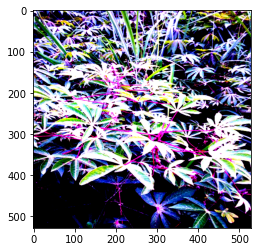

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

img = inputs[0, ...].data.cpu().numpy()
img = img.transpose(1,2,0)
plt.imshow(img)

In [3]:
img = transforms.ColorJitter(contrast=(0.8, 1.2))(inputs[0, ...])
img = img.reshape(1, *img.shape)
with torch.no_grad():
    o2 = net(img)
    o2 = torch.softmax(o2, dim=1)
o2

tensor([[0.0475, 0.3569, 0.1317, 0.2667, 0.1973]], device='cuda:0')

In [4]:
with torch.no_grad():
    o3 = net(transforms.RandomHorizontalFlip()(inputs))
    o3 = torch.softmax(o3, dim=1)
o3

tensor([[0.1197, 0.1234, 0.2726, 0.0953, 0.3890]], device='cuda:0')

In [5]:
with torch.no_grad():
    o4 = net(transforms.RandomVerticalFlip()(inputs))
    o4 = torch.softmax(o3, dim=1)
o4

tensor([[0.1834, 0.1840, 0.2136, 0.1789, 0.2400]], device='cuda:0')

In [8]:
o = (o1 + o2 + o3 +o4) / 4
o

tensor([[0.1067, 0.2240, 0.1922, 0.2035, 0.2735]], device='cuda:0')

In [9]:
o.sum()

tensor(1., device='cuda:0')

In [19]:
with torch.no_grad():
    ots = net(inputs)
    pred = torch.softmax(ots, dim=1)
pred

tensor([[0.1422, 0.1419, 0.2062, 0.0653, 0.4444]], device='cuda:0')

In [40]:
from PIL import Image

with torch.no_grad():
    o5_img = Image.open(os.path.join(test_path, '2216849948.jpg'))
    trans = transforms.Compose([
        transforms.Resize((528, 528)),
        transforms.RandomRotation(30),
        # transforms.RandomCrop((528, 528), padding=3),
        transforms.ToTensor(),
        transforms.Normalize([0.4304, 0.4968, 0.3135], [0.2358, 0.2387, 0.2256])
    ])
    o5 = net(trans(o5_img).unsqueeze(0))
    o5 = torch.softmax(o5, dim=1)
o5
# transforms.RandomCrop((528, 528), padding=3),

tensor([[0.1028, 0.1769, 0.1810, 0.1074, 0.4319]], device='cuda:0')

In [22]:
os.listdir(test_path)

['2216849948.jpg']